# Physical models of living system

### Modelling small-patterned neuronal networks coupled to microelectrode arrays

Author: Nguyen Xuan Tung

Id: 2005491

-------------------------------------------------------------------------------------------------------

### Simulation of spiking neuron

A spiking neuron is a type of computational model used to simulate the activity of real neurons in the brain. Unlike other models that represent neurons as continuous variables, spiking neuron models simulate the discrete electrical pulses, or spikes, that neurons use to communicate with one another.

The basic spiking neuron model consists of three main components: a dendritic tree that receives input signals from other neurons, a soma that integrates these signals and generates output, and an axon that transmits the output signals to other neurons. The output of the neuron is modeled as a series of spikes that occur when the membrane potential of the soma reaches a certain threshold.

The spiking neuron model can be used to simulate various neural processes, such as neural encoding, decoding, and plasticity. They are also widely used in the study of neural networks and the analysis of neural data.

In this notebook, python library which is called neuron is implemented to simulate the spiking of neurons. The neuron library is a powerful simulation environment for computational neuroscience. It provides tools and functions for building, simulating, and analyzing biologically realistic neural models. The library is primarily used with the programming language Python, allowing researchers and scientists to leverage its capabilities for studying and understanding the behavior of individual neurons and networks of neurons.

### Library

In [1]:
!pip install neuron 

You should consider upgrading via the 'c:\users\admin\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [2]:
import random
import numpy as np
import networkx as nx
from neuron import h, gui
from scipy.io import loadmat
import matplotlib.pyplot as plt

### Simulation of isolated neuron

In [3]:
# Define the neuron model
soma = h.Section(name='soma')
soma.L = 30
soma.diam = 30
soma.insert('hh')

soma

In [4]:
# Define the dendrites
num_dendrites_list = [1, 3, 5, 9]  # List of number of dendrites

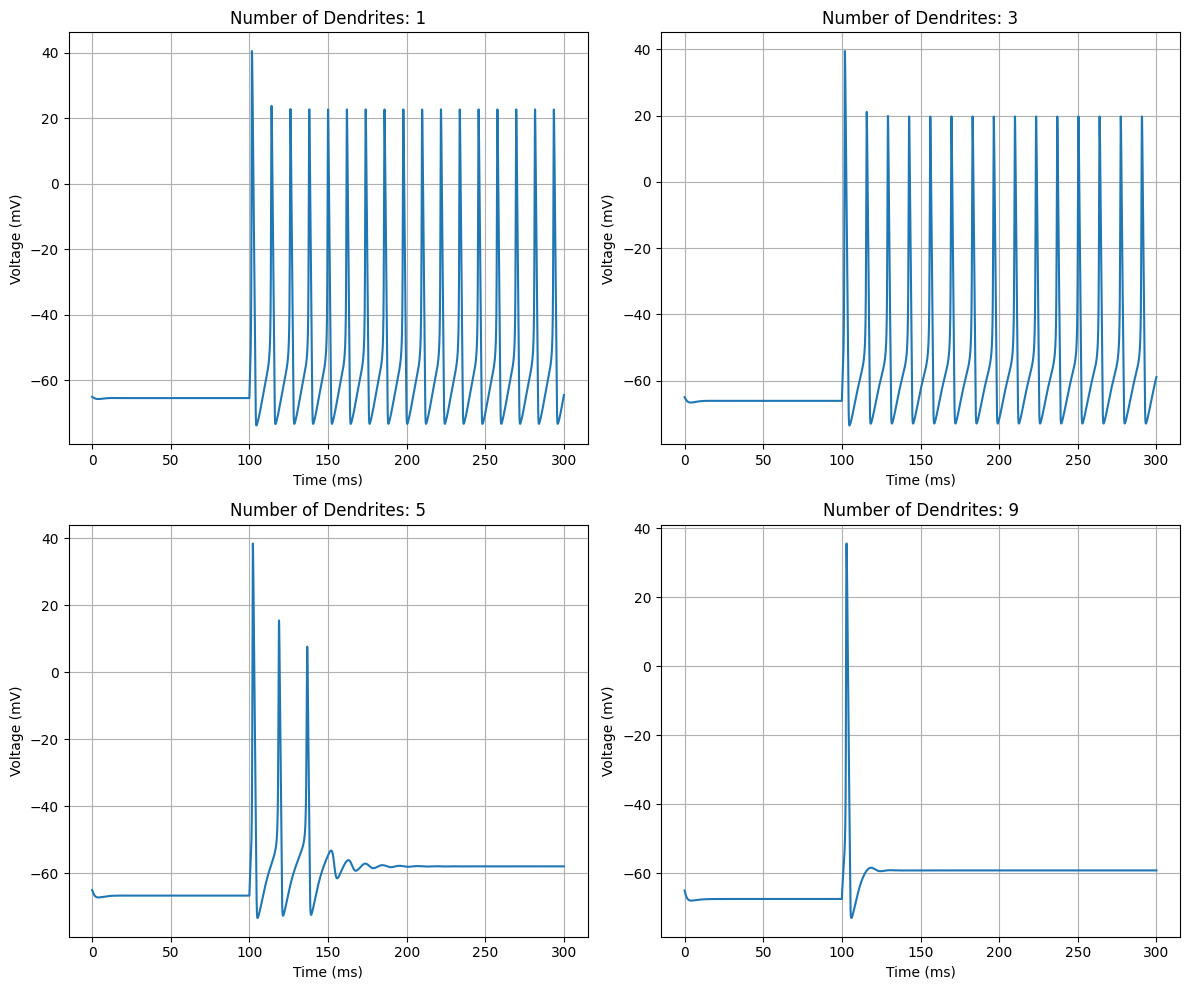

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
for idx, num_dendrites in enumerate(num_dendrites_list):
    row = idx // 2  # Determine the row index for the subplot
    col = idx % 2  # Determine the column index for the subplot

    dendrites = []
    for i in range(num_dendrites):
        dend = h.Section(name=f'dend{i}')
        dend.L = 100
        dend.diam = 1
        dend.insert('pas')
        dend.connect(soma(0.5))
        dendrites.append(dend)

    # Define the synapses
    synapses = []
    for i, dend in enumerate(dendrites):
        syn = h.ExpSyn(dend(0.5))
        syn.e = 0
        syn.tau = 2
        synapses.append(syn)

    # Connect the neuron to a current clamp
    stim = h.IClamp(soma(0.5))
    stim.delay = 100
    stim.dur = 1500
    stim.amp = 0.6

    # Record the spiking activity
    soma_v = h.Vector().record(soma(0.5)._ref_v)
    t = h.Vector().record(h._ref_t)

    # Run the simulation
    h.tstop = 300
    h.run()

    # Plot the results in the corresponding subplot
    axs[row, col].plot(t, soma_v)
    axs[row, col].set_xlabel('Time (ms)')
    axs[row, col].set_ylabel('Voltage (mV)')
    axs[row, col].set_title(f'Number of Dendrites: {num_dendrites}')
    axs[row, col].grid()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.savefig("Isolated_nenuron.JPEG")
plt.show()

----------------------------------------------------------------------------------------------------------------

### Simulation of connected neuron in 8x8 neurons group

To simulate the condition of
spontaneous activity, we added a Gaussian noise source to the
leakage channels of each component of the neuron models. Neurons are intrinsically noisy and several
sources were identified. The most dominant source of such
electrical noise is channel noise, i.e., electrical currents caused
by the random opening and closing of the ion channels.


In [6]:
# Define the neuron model
soma = h.Section(name='soma')
soma.L = 30
soma.diam = 30
soma.insert('hh')

soma

In [7]:
# Define the dendrites
num_dendrites_list = [1, 3, 5, 9]  # List of number of dendrites

In [8]:
# Define the 8x8 neuron group
num_neurons_x = 8
num_neurons_y = 8
neurons = [[h.Section(name=f'neuron_{i}_{j}') for j in range(num_neurons_y)] for i in range(num_neurons_x)]

In [9]:
# Generate X and Y coordinates for each neuron
x_coords = []
y_coords = []
for i in range(num_neurons_x):
    for j in range(num_neurons_y):
        neuron = neurons[i][j]
        x_coords.append(j)
        y_coords.append(i)


In [10]:
# Create the neurons and store them in the 8x8 grid
for i in range(num_neurons_x):
    for j in range(num_neurons_y):
        neuron = h.Section(name=f'neuron_{i}_{j}')
        neuron.L = 30
        neuron.diam = 30
        neuron.insert('hh')
        neurons[i][j] = neuron

# Choose a random neuron from the 8x8 grid
random_neuron = neurons[random.randint(0, num_neurons_x-1)][random.randint(0, num_neurons_y-1)]
print(random_neuron)

neuron_6_6


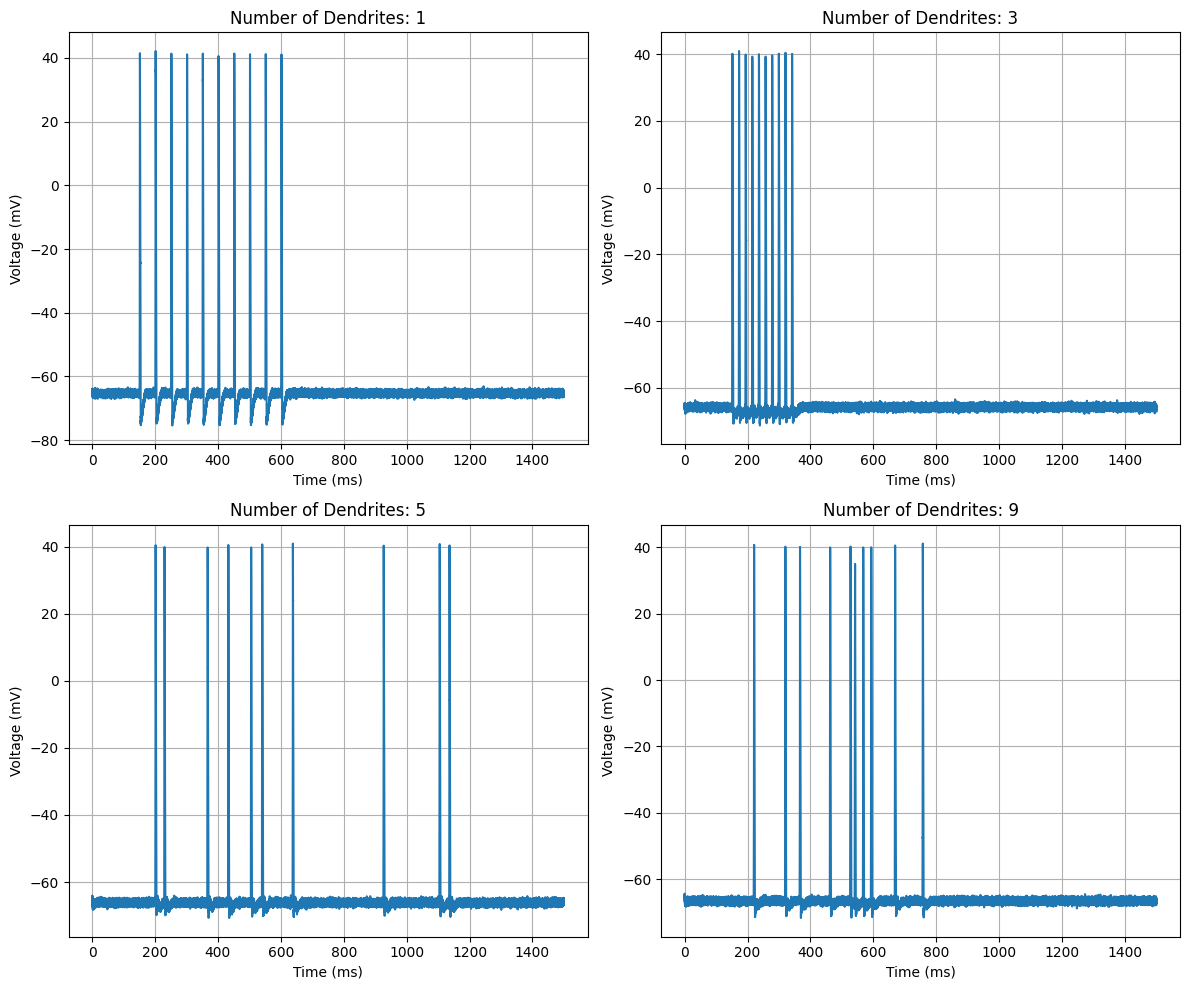

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
for idx, num_dendrites in enumerate(num_dendrites_list):
    row = idx // 2  # Determine the row index for the subplot
    col = idx % 2  # Determine the column index for the subplot

    dendrites = []
    for i in range(num_dendrites):
        dend = h.Section(name=f'dend{i}')
        dend.L = 100
        dend.diam = 1
        dend.insert('pas')
        dend.insert('hh')  # Insert the 'hh' mechanism in the dendrite
        dend.connect(random_neuron(0.5))
        dendrites.append(dend)


    # Define the synapses with different weights based on the number of dendrites
    synapses = []
    for i, dend in enumerate(dendrites):
        syn = h.ExpSyn(dend(0.5))
        syn.e = 0
        syn.tau = 2
        
        if num_dendrites == 1:
            # Create NetStim for isolated spike
            netstim = h.NetStim()
            netstim.start = 150  # Start time of the stimulation
            netstim.noise = 0.0  # Set noise level to 0 for isolated spike
            delay = 50  # Fixed delay of 50 ms for isolated spike
            netstim.interval = delay

            # Connect NetStim to ExpSyn via NetCon
            netcon = h.NetCon(netstim, syn)
            netcon.weight[0] = 0.1  # Set the synaptic weight
            
        elif num_dendrites == 3:
            # Create NetStim for tonic spike
            netstim = h.NetStim()
            netstim.start = 150  # Start time of the stimulation
            netstim.noise = 0.0  # Set noise level to 0 for tonic spike
            delay = random.uniform(1, 100)  # Random delay 
            netstim.interval = delay

            # Connect NetStim to ExpSyn via NetCon
            netcon = h.NetCon(netstim, syn)
            netcon.weight[0] = 1  # Set the synaptic weight
        
        else:
            # Create NetStim for random delays
            netstim = h.NetStim()
            netstim.start = 150  # Start time of the stimulation
            netstim.noise = 0.8  # Set noise level
            delay = random.uniform(1, 200)  # Random delay 
            netstim.interval = delay

            # Connect NetStim to ExpSyn via NetCon
            netcon = h.NetCon(netstim, syn)
            netcon.weight[0] = 2  # Set the synaptic weight
        
        
        synapses.append(syn)

    # Record the spiking activity
    soma_v = h.Vector().record(random_neuron(0.5)._ref_v)
    t = h.Vector().record(h._ref_t)

    # Run the simulation
    h.tstop = 1500
    h.run()
    
    # Apply Gaussian noise 
    mean = 0
    std = 0.5  # Standard deviation of the Gaussian noise
    noise = np.random.normal(mean, std, len(soma_v))
    soma_v += noise

    # Plot the results in the corresponding subplot
    axs[row, col].plot(t, soma_v)
    axs[row, col].set_xlabel('Time (ms)')
    axs[row, col].set_ylabel('Voltage (mV)')
    axs[row, col].set_title(f'Number of Dendrites: {num_dendrites}')
    #axs[row, col].set_xlim([100,800])
    axs[row, col].grid()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.savefig("Connected_nenuron.JPEG")
plt.show()

-----------------------------------------------------------------------------------------------------------------

### Network connectivity

One to many (OTM) rule states that each meta-neuron can establish
several random connections (both excitatory and inhibitory)
to the neighbours (maximum value: 30) and few connections
(minimum value: 0) as far as the distance increases; the closer
the two meta-neurons are, the more connected they are, and
thus the synaptic efficacy of the connection is increased.

One to neighbors (OTN) rule defines a local connectivity and states that
each meta-neuron is only connected to its nearest neighbours
(up to eight meta-neurons).

In [12]:
def compute_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

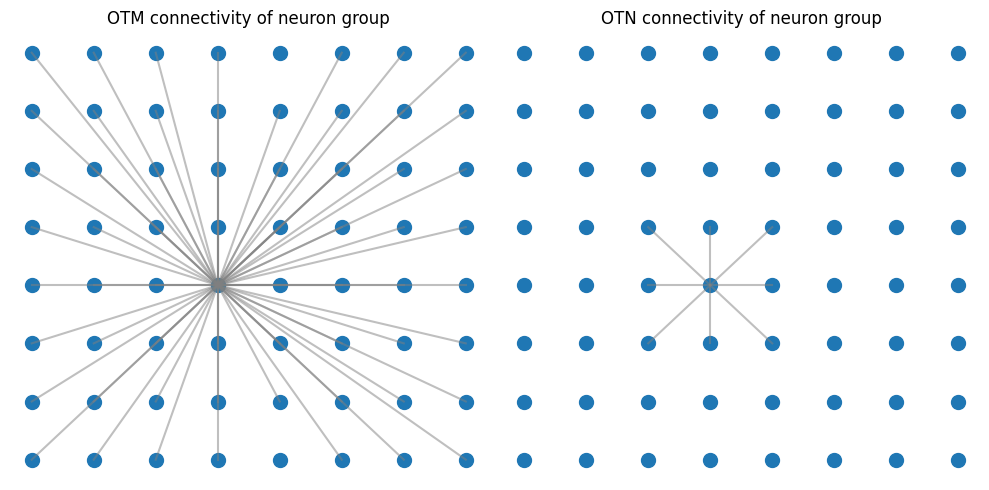

In [13]:
# Generate X and Y coordinates for each neuron
x_coords = []
y_coords = []
for i in range(num_neurons_x):
    for j in range(num_neurons_y):
        neuron = neurons[i][j]
        x_coords.append(j)
        y_coords.append(i)

# Set the parameters for the second code
num_neurons_group_1 = num_neurons_x * num_neurons_y
distances_group_1 = np.zeros((num_neurons_group_1, num_neurons_group_1))


# Calculate the distances between neurons in the group
for i in range(num_neurons_group_1):
    for j in range(i + 1, num_neurons_group_1):
        distances_group_1[i, j] = compute_distance(x_coords[i], y_coords[i], x_coords[j], y_coords[j])
        distances_group_1[j, i] = distances_group_1[i, j]


# Set the seed for reproducibility
np.random.seed(1234)
# Define the parameters for OTM and OTN connectivity
OTM_connections = 20
OTN_connections = 5
synaptic_weights_OTM = np.zeros((num_neurons_group_1, num_neurons_group_1))
synaptic_weights_OTN = np.zeros((num_neurons_group_1, num_neurons_group_1))

center_x = np.mean(x_coords)  # X coordinate of the center
center_y = np.mean(y_coords)  # Y coordinate of the center
center_neuron_index = np.argmin(compute_distance(x_coords, y_coords, center_x, center_y)) 


# Generate synaptic weights for OTN connectivity
for i in range(num_neurons_group_1):
    for j in range(i + 1, num_neurons_group_1):
        distance = distances_group_1[i, j]
        synaptic_weights_OTM[i, j] = np.random.randint(0, OTM_connections) * (1 / distance)
        synaptic_weights_OTM[j, i] = synaptic_weights_OTM[i, j]

        if i != j:
            if i == center_neuron_index or j == center_neuron_index:
                if distance <= np.sqrt(2):
                    synaptic_weights_OTN[i, j] = np.random.uniform(0, OTN_connections)
                    synaptic_weights_OTN[j, i] = synaptic_weights_OTN[i, j]
            elif distance <= np.sqrt(2):
                synaptic_weights_OTN[i, j] = np.random.uniform(0, OTN_connections)
                synaptic_weights_OTN[j, i] = synaptic_weights_OTN[i, j]
                
            
# Create scatter plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(x_coords, y_coords, s=100)
for i in range(num_neurons_group_1):
    if i != center_neuron_index and synaptic_weights_OTM[center_neuron_index, i] > 0:
        plt.plot([x_coords[center_neuron_index], x_coords[i]], [y_coords[center_neuron_index], y_coords[i]], color='gray', alpha=0.5)
plt.axis('off')
plt.title('OTM connectivity of neuron group')

plt.subplot(1, 2, 2)
plt.scatter(x_coords, y_coords, s=100)
for i in range(num_neurons_group_1):
    if i != center_neuron_index and synaptic_weights_OTN[center_neuron_index, i] > 0:
        plt.plot([x_coords[center_neuron_index], x_coords[i]], [y_coords[center_neuron_index], y_coords[i]], color='gray', alpha=0.5)
plt.axis('off')
plt.title('OTN connectivity of neuron group')

plt.tight_layout()
plt.show()


------------------------------------------------------------------------------------------------------------------

### Simulation of connected neuron in 8x8 neurons group

In [14]:
random.seed(1234)  # Set the random seed to a specific value

In [15]:
# Define the neuron model
soma = h.Section(name='soma')
soma.L = 30
soma.diam = 30
soma.insert('hh')

soma

In [16]:
# Define the dendrites
num_dendrites_list = [1, 3, 5, 9, 12]  # List of number of dendrites

In [17]:
# Define the 8x8 neuron group
num_neurons_x = 8
num_neurons_y = 8
neurons = [[h.Section(name=f'neuron_{i}_{j}') for j in range(num_neurons_y)] for i in range(num_neurons_x)]

In [18]:
# Generate X and Y coordinates for each neuron
x_coords = []
y_coords = []
for i in range(num_neurons_x):
    for j in range(num_neurons_y):
        neuron = neurons[i][j]
        x_coords.append(j)
        y_coords.append(i)


In [19]:
# Create the neurons and store them in the 8x8 grid
for i in range(num_neurons_x):
    for j in range(num_neurons_y):
        neuron = h.Section(name=f'neuron_{i}_{j}')
        neuron.L = 30
        neuron.diam = 30
        neuron.insert('hh')
        neurons[i][j] = neuron

# Choose a random neuron from the 8x8 grid
random_neuron = neurons[random.randint(0, num_neurons_x-1)][random.randint(0, num_neurons_y-1)]
print(random_neuron)

neuron_7_1


### Create OTM and OTN connectivity rules

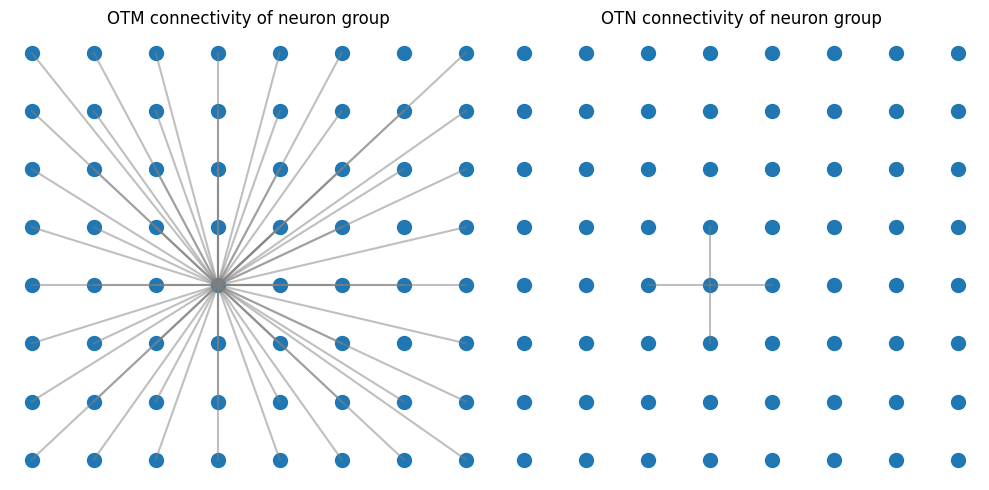

In [20]:
# Generate X and Y coordinates for each neuron
x_coords = []
y_coords = []
for i in range(num_neurons_x):
    for j in range(num_neurons_y):
        neuron = neurons[i][j]
        x_coords.append(j)
        y_coords.append(i)

# Set the parameters for the second code
num_neurons_group_1 = num_neurons_x * num_neurons_y
distances_group_1 = np.zeros((num_neurons_group_1, num_neurons_group_1))


# Calculate the distances between neurons in the group
for i in range(num_neurons_group_1):
    for j in range(i + 1, num_neurons_group_1):
        distances_group_1[i, j] = compute_distance(x_coords[i], y_coords[i], x_coords[j], y_coords[j])
        distances_group_1[j, i] = distances_group_1[i, j]


# Set the seed for reproducibility
np.random.seed(1234)
# Define the parameters for OTM and OTN connectivity
OTM_connections = 20
OTN_connections = 20
synaptic_weights_OTM = np.zeros((num_neurons_group_1, num_neurons_group_1))
synaptic_weights_OTN = np.zeros((num_neurons_group_1, num_neurons_group_1))

center_x = np.mean(x_coords)  # X coordinate of the center
center_y = np.mean(y_coords)  # Y coordinate of the center
center_neuron_index = np.argmin(compute_distance(x_coords, y_coords, center_x, center_y)) 


# Generate synaptic weights for connectivity
for i in range(num_neurons_group_1):
    for j in range(i + 1, num_neurons_group_1):
        distance = distances_group_1[i, j]
        synaptic_weights_OTM[i, j] = np.random.randint(0, OTM_connections) * (1 / distance)
        synaptic_weights_OTM[j, i] = synaptic_weights_OTM[i, j]

        if i != j:
            if i == center_neuron_index or j == center_neuron_index:
                if distance == 1:  # Connect only to direct neighbors
                    synaptic_weights_OTN[i, j] = np.random.uniform(0, OTN_connections)
                    synaptic_weights_OTN[j, i] = synaptic_weights_OTN[i, j]
            elif distance == 1:  # Connect only to direct neighbors
                synaptic_weights_OTN[i, j] = np.random.uniform(0, OTN_connections)
                synaptic_weights_OTN[j, i] = synaptic_weights_OTN[i, j]
                
            
# Create scatter plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(x_coords, y_coords, s=100)
for i in range(num_neurons_group_1):
    if i != center_neuron_index and synaptic_weights_OTM[center_neuron_index, i] > 0:
        plt.plot([x_coords[center_neuron_index], x_coords[i]], [y_coords[center_neuron_index], y_coords[i]], color='gray', alpha=0.5)
plt.axis('off')
plt.title('OTM connectivity of neuron group')

plt.subplot(1, 2, 2)
plt.scatter(x_coords, y_coords, s=100)
for i in range(num_neurons_group_1):
    if i != center_neuron_index and synaptic_weights_OTN[center_neuron_index, i] > 0:
        plt.plot([x_coords[center_neuron_index], x_coords[i]], [y_coords[center_neuron_index], y_coords[i]], color='gray', alpha=0.5)
plt.axis('off')
plt.title('OTN connectivity of neuron group')

plt.tight_layout()
plt.show()


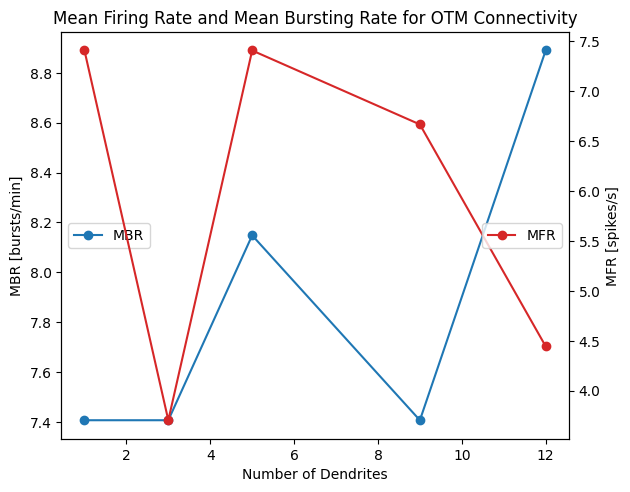

In [32]:
# Connect all neurons together (OTM connectivity)
for i in range(num_neurons_x):
    for j in range(num_neurons_y):
        for k in range(num_neurons_x):
            for l in range(num_neurons_y):
                if i != k or j != l:
                    dend = neurons[k][l]
                    syn = h.ExpSyn(dend(0.5))
                    syn.e = 0
                    syn.tau = 2

                    netcon = h.NetCon(neurons[i][j](0.5)._ref_v, syn, sec=neurons[i][j])
                    netcon.weight[0] = 1.0

mean_firing_rates = []  # List to store mean firing rates
mean_bursting_rates = []  # List to store mean bursting rates

for idx, num_dendrites in enumerate(num_dendrites_list):
    row = idx // 2  # Determine the row index for the subplot
    col = idx % 2  # Determine the column index for the subplot

    dendrites = []
    for i in range(num_dendrites):
        dend = h.Section(name=f'dend{i}')
        dend.L = 100
        dend.diam = 1
        dend.insert('pas')
        dend.insert('hh')  # Insert the 'hh' mechanism in the dendrite
        dend.connect(random_neuron(0.5))
        dendrites.append(dend)

    # Define the synapses with different weights based on the number of dendrites
    synapses = []
    for i, dend in enumerate(dendrites):
        syn = h.ExpSyn(dend(0.5))
        syn.e = 0
        syn.tau = 2

        if num_dendrites == 1:
            # Create NetStim for isolated spike
            netstim = h.NetStim()
            netstim.start = 150  # Start time of the stimulation
            netstim.noise = 0.0  # Set noise level to 0 for isolated spike
            delay = 50  # Fixed delay of 50 ms for isolated spike
            netstim.interval = delay

            # Connect NetStim to ExpSyn via NetCon
            netcon = h.NetCon(netstim, syn)
            netcon.weight[0] = 0.1  # Set the synaptic weight

        elif num_dendrites == 3:
            # Create NetStim for tonic spike
            netstim = h.NetStim()
            netstim.start = 150  # Start time of the stimulation
            netstim.noise = 0.0  # Set noise level to 0 for tonic spike
            delay = random.uniform(1, 100)  # Random delay
            netstim.interval = delay

            # Connect NetStim to ExpSyn via NetCon
            netcon = h.NetCon(netstim, syn)
            netcon.weight[0] = 1  # Set the synaptic weight

        else:
            # Create NetStim for random delays
            netstim = h.NetStim()
            netstim.start = 150  # Start time of the stimulation
            netstim.noise = 0.8  # Set noise level
            delay = random.uniform(1, 200)  # Random delay
            netstim.interval = delay

            # Connect NetStim to ExpSyn via NetCon
            netcon = h.NetCon(netstim, syn)
            netcon.weight[0] = 1  # Set the synaptic weight

        synapses.append(syn)

    # Record the spiking activity
    soma_v = h.Vector().record(random_neuron(0.5)._ref_v)
    t = h.Vector().record(h._ref_t)

    # Run the simulation
    h.tstop = 1500
    h.run()

    # Apply Gaussian noise
    mean = 0
    std = 0.5  # Standard deviation of the Gaussian noise
    noise = np.random.normal(mean, std, len(soma_v))
    soma_v += noise

    # Threshold for spike detection
    threshold = -20

    # Detect spikes
    spike_times = []
    for j in range(len(soma_v) - 1):
        if soma_v[j] < threshold and soma_v[j + 1] >= threshold:
            spike_times.append(t[j + 1])

    # Calculate firing rate
    firing_rate = len(spike_times) / ((h.tstop - 150) / 1000.0)  # Exclude the initial 150 ms
    mean_firing_rates.append(firing_rate)

    # Calculate bursting rate
    burst_threshold = 200  # Inter-spike interval threshold for burst detection
    burst_count = 10
    burst_start_time = spike_times[0]
    for j in range(1, len(spike_times)):
        if spike_times[j] - spike_times[j - 1] > burst_threshold:
            burst_count += 1
            burst_start_time = spike_times[j]

    bursting_rate = burst_count / ((h.tstop - 150) / 1000.0)  # Exclude the initial 150 ms
    mean_bursting_rates.append(bursting_rate)


# Plot the Mean Firing Rate and Mean Bursting Rate
fig, ax1 = plt.subplots()

ax1.plot(num_dendrites_list, mean_bursting_rates, marker='o', label='MBR')
ax1.set_xlabel('Number of Dendrites')
ax1.set_ylabel('MBR [bursts/min]')

ax2 = ax1.twinx()
ax2.plot(num_dendrites_list, mean_firing_rates, marker='o', label='MFR', color='tab:red')
ax2.set_ylabel('MFR [spikes/s]')

# Move the legend inside the plot
ax1.legend(loc='center left')
ax2.legend(loc='center right')

# Adjust the plot layout to fit the legend
plt.tight_layout()

plt.title('Mean Firing Rate and Mean Bursting Rate for OTM Connectivity')
plt.show()

neuron_1_1


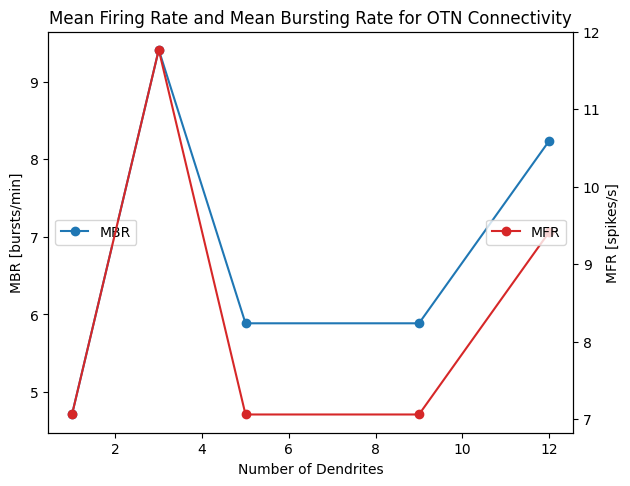

In [54]:
# Connect each neuron to its neighboring neurons
for i in range(num_neurons_x):
    for j in range(num_neurons_y):
        neuron = neurons[i][j]
        if i > 0:
            dend = neurons[i - 1][j]
            syn = h.ExpSyn(dend(0.5))
            syn.e = 0
            syn.tau = 2

            netcon = h.NetCon(neuron(0.5)._ref_v, syn, sec=neuron)
            netcon.weight[0] = 1.0

        if i < num_neurons_x - 1:
            dend = neurons[i + 1][j]
            syn = h.ExpSyn(dend(0.5))
            syn.e = 0
            syn.tau = 2

            netcon = h.NetCon(neuron(0.5)._ref_v, syn, sec=neuron)
            netcon.weight[0] = 1.0

        if j > 0:
            dend = neurons[i][j - 1]
            syn = h.ExpSyn(dend(0.5))
            syn.e = 0
            syn.tau = 2

            netcon = h.NetCon(neuron(0.5)._ref_v, syn, sec=neuron)
            netcon.weight[0] = 1.0

        if j < num_neurons_y - 1:
            dend = neurons[i][j + 1]
            syn = h.ExpSyn(dend(0.5))
            syn.e = 0
            syn.tau = 2

            netcon = h.NetCon(neuron(0.5)._ref_v, syn, sec=neuron)
            netcon.weight[0] = 1.0

# Choose a random neuron from the 8x8 grid
random_neuron = neurons[random.randint(0, num_neurons_x-1)][random.randint(0, num_neurons_y-1)]
print(random_neuron)


mean_firing_rates = []
mean_bursting_rates = []

for num_dendrites in num_dendrites_list:
    dendrites = []
    for _ in range(num_dendrites):
        dend = h.Section(name=f'dend')
        dend.L = 100
        dend.diam = 1
        dend.insert('pas')
        dend.insert('hh')
        dend.connect(random_neuron(0.5))
        dendrites.append(dend)

    synapses = []
    for dend in dendrites:
        syn = h.ExpSyn(dend(0.5))
        syn.e = 0
        syn.tau = 2

        netstim = h.NetStim()
        netstim.start = random.uniform(100, 500)  # Random start time
        netstim.noise = 0.8  # Set noise level
        delay = random.uniform(1, 200)  # Random delay
        netstim.interval = delay

        netcon = h.NetCon(netstim, syn)
        netcon.weight[0] = 1.0

        synapses.append(syn)

    soma_v = h.Vector().record(random_neuron(0.5)._ref_v)
    t = h.Vector().record(h._ref_t)

    h.tstop = 1000
    h.run()

    # Apply Gaussian noise
    mean = 0
    std = 0.5  # Standard deviation of the Gaussian noise
    noise = np.random.normal(mean, std, len(soma_v))
    soma_v += noise

    # Threshold for spike detection
    threshold = -20

    # Detect spikes
    spike_times = []
    for j in range(len(soma_v) - 1):
        if soma_v[j] < threshold and soma_v[j + 1] >= threshold:
            spike_times.append(t[j + 1])

    # Calculate firing rate
    firing_rate = len(spike_times) / ((h.tstop - 150) / 1000.0)  # Exclude the initial 150 ms
    mean_firing_rates.append(firing_rate)

    # Calculate bursting rate
    burst_threshold = 20 # Inter-spike interval threshold for burst detection
    burst_count = 0
    burst_start_time = spike_times[0]
    for j in range(1, len(spike_times)):
        if spike_times[j] - spike_times[j - 1] > burst_threshold:
            burst_count += 1
            burst_start_time = spike_times[j]

    bursting_rate = burst_count / ((h.tstop - 150) / 1000.0)  # Exclude the initial 150 ms
    mean_bursting_rates.append(bursting_rate)


# Plot the Mean Firing Rate and Mean Bursting Rate
fig, ax1 = plt.subplots()

ax1.plot(num_dendrites_list, mean_bursting_rates, marker='o', label='MBR')
ax1.set_xlabel('Number of Dendrites')
ax1.set_ylabel('MBR [bursts/min]')

ax2 = ax1.twinx()
ax2.plot(num_dendrites_list, mean_firing_rates, marker='o', label='MFR', color='tab:red')
ax2.set_ylabel('MFR [spikes/s]')

# Move the legend inside the plot
ax1.legend(loc='center left')
ax2.legend(loc='center right')

# Adjust the plot layout to fit the legend
plt.tight_layout()

plt.title('Mean Firing Rate and Mean Bursting Rate for OTN Connectivity')
plt.show()

-------------------------------------------------------------------------------------------------------

In [23]:
# Load the .mat file
data = loadmat('combined_data.mat')

In [24]:
random.seed(1234)  # Set the random seed to a specific value

In [25]:
group_labels = data['group_labels']
group_1_indices = np.where(group_labels == 1)[1]
group_1_x = data['x'][group_1_indices]
group_1_y = data['y'][group_1_indices]

In [26]:
num_neurons_group_1 = len(group_1_indices)
distances_group_1 = np.zeros((num_neurons_group_1, num_neurons_group_1))

for i in range(num_neurons_group_1):
    for j in range(i + 1, num_neurons_group_1):
        distances_group_1[i, j] = compute_distance(group_1_x[i], group_1_y[i], group_1_x[j], group_1_y[j])
        distances_group_1[j, i] = distances_group_1[i, j]
        

OTM_connections = 60
OTN_connections = 60
synaptic_weights_OTM = np.zeros((num_neurons_group_1, num_neurons_group_1))
synaptic_weights_OTN = np.zeros((num_neurons_group_1, num_neurons_group_1))

center_x = np.mean(group_1_x)  # X coordinate of the center
center_y = np.mean(group_1_y)  # Y coordinate of the center
center_neuron_index = np.argmin(compute_distance(group_1_x, group_1_y, center_x, center_y))

# Generate synaptic weights for connectivity
for i in range(num_neurons_group_1):
    for j in range(i + 1, num_neurons_group_1):
        distance = distances_group_1[i, j]
        synaptic_weights_OTM[i, j] = np.random.randint(0, OTM_connections) * (1 / distance)
        synaptic_weights_OTM[j, i] = synaptic_weights_OTM[i, j]

        if i != j:
            if i == center_neuron_index or j == center_neuron_index:
                if distance == 1:  # Connect only to direct neighbors
                    synaptic_weights_OTN[i, j] = np.random.uniform(0, OTN_connections)
                    synaptic_weights_OTN[j, i] = synaptic_weights_OTN[i, j]
            elif distance == 1:  # Connect only to direct neighbors
                synaptic_weights_OTN[i, j] = np.random.uniform(0, OTN_connections)
                synaptic_weights_OTN[j, i] = synaptic_weights_OTN[i, j]


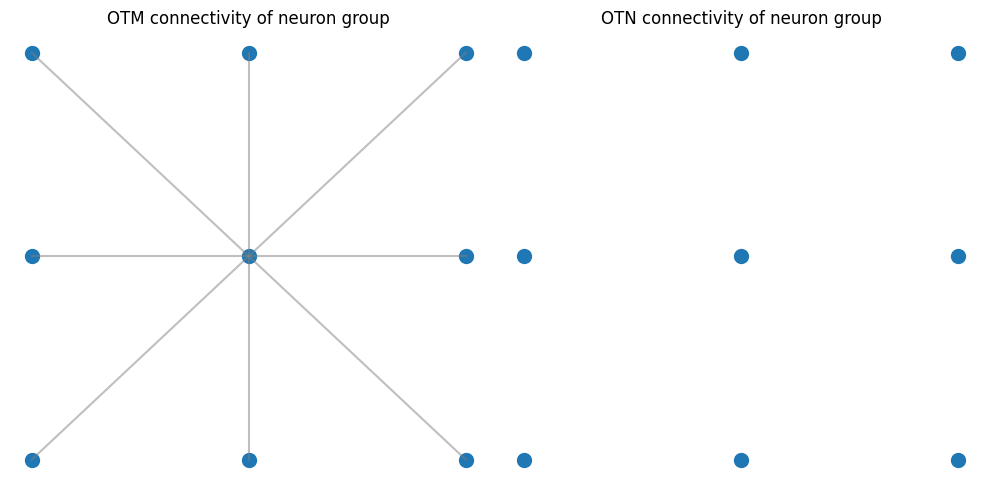

In [27]:
# Create scatter plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(group_1_x, group_1_y, s=100)
for i in range(num_neurons_group_1):
    if i != center_neuron_index and synaptic_weights_OTM[center_neuron_index, i] > 0:
        plt.plot([group_1_x[center_neuron_index], group_1_x[i]], [group_1_y[center_neuron_index], group_1_y[i]], color='gray', alpha=0.5)
plt.axis('off')
plt.title('OTM connectivity of neuron group')

plt.subplot(1, 2, 2)
plt.scatter(group_1_x, group_1_y, s=100)
for i in range(num_neurons_group_1):
    if i != center_neuron_index and synaptic_weights_OTN[center_neuron_index, i] > 0:
        plt.plot([group_1_x[center_neuron_index], group_1_x[i]], [group_1_y[center_neuron_index], group_1_y[i]], color='gray', alpha=0.5)
plt.axis('off')
plt.title('OTN connectivity of neuron group')

plt.tight_layout()
plt.show()

In [28]:
burst_indices = np.where(group_labels == 1)[1]
burst_starts = np.where(np.diff(burst_indices) > 1)[0] + 1
burst_ends = np.where(np.diff(burst_indices) < -1)[0] + 1
ibis = np.diff(burst_starts)


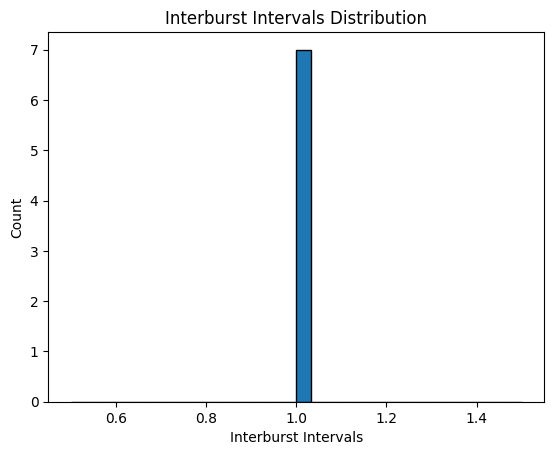

In [29]:
plt.hist(ibis, bins=30, edgecolor='black')
plt.xlabel('Interburst Intervals')
plt.ylabel('Count')
plt.title('Interburst Intervals Distribution')
plt.show()
